In [1]:
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
# Read in the data from the Excel file
excel_file = pd.ExcelFile('dispersionLara_splithalf_freqprop.xlsx')
columns_to_use = ['words', 'splithalf', 'totalfreq', 'freqproportion','zscore']
df1 = pd.read_excel(excel_file, sheet_name='Lara', usecols=columns_to_use)
df2 = pd.read_excel(excel_file, sheet_name='Sod', usecols=columns_to_use)
df3 = pd.read_excel(excel_file, sheet_name='Sam', usecols=columns_to_use)

# Convert each dataframe into an xarray dataset
ds_Lara = xr.Dataset.from_dataframe(df1)
ds_Sod = xr.Dataset.from_dataframe(df2)
ds_Sam = xr.Dataset.from_dataframe(df3)

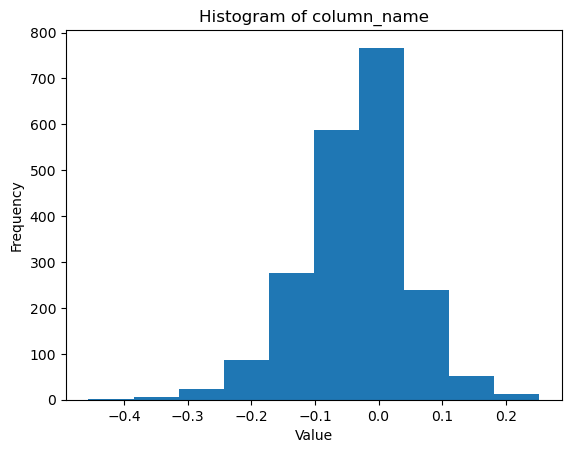

In [3]:
# Take the splithalf DPNorm values for each corpus
splithalf_Lara = ds_Lara['splithalf'].values
splithalf_Sod = ds_Sod['splithalf'].values
splithalf_Sam = ds_Sam['splithalf'].values

# Create a histogram
plt.hist(splithalf_Lara, bins=10)  # You can adjust the number of bins as needed

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Lara splithalf')

# Show the plot
plt.show()

In [3]:
# Filter dataframe based on zscore within the range [-0.25, 0.25]
ds_Lara_filtered = ds_Lara.where((ds_Lara['zscore'] >= -0.25) & (ds_Lara['zscore'] <= 0.25), drop=True)
ds_Sod_filtered = ds_Sod.where((ds_Sod['zscore'] >= -0.25) & (ds_Sod['zscore'] <= 0.25), drop=True)
ds_Sam_filtered = ds_Sam.where((ds_Sam['zscore'] >= -0.25) & (ds_Sam['zscore'] <= 0.25), drop=True)

ds_Lara_filtered = ds_Lara_filtered.sortby('words')
ds_Lara_filtered= ds_Lara_filtered.reset_index('index',drop=True)
ds_Sod_filtered = ds_Sod_filtered.sortby('words')
ds_Sod_filtered= ds_Sod_filtered.reset_index('index',drop=True)
ds_Sam_filtered = ds_Sam_filtered.sortby('words')
ds_Sam_filtered= ds_Sam_filtered.reset_index('index',drop=True)

In [4]:
# Sort dataframe by splithalf DPNorm value
ds_Sod_sorted = ds_Sod_filtered.sortby('splithalf')
ds_Lara_sorted = ds_Lara_filtered.sortby('splithalf')
ds_Sam_sorted = ds_Sam_filtered.sortby('splithalf')

df_Sod = ds_Sod_sorted.to_dataframe()
df_Lara = ds_Lara_sorted.to_dataframe()
df_Sam = ds_Sam_sorted.to_dataframe()

In [6]:
# Get the median splithalf value
#df_Sod['splithalf'].median()
#df_Lara['splithalf'].median()
#df_Sam['splithalf'].median()

0.03570509065464811

In [1]:
#Find words around the median splithalf value found above
#df_Sod[83:86]
#df_Lara[973:976]
#df_Sam[696:699]

NameError: name 'df_Sam' is not defined

In [15]:
# Check which words in Lara corpus are also present in Soderstrom corpus
common_words = ds_Lara_filtered['words'].isin(ds_Sod_filtered['words'])

# Extract frequency, split-half, and frequency proportion values from Soderstrom and Lara for common words
frequency_Sod = ds_Sod_filtered['totalfreq'].where(ds_Sod_filtered['words'].isin(ds_Lara_filtered['words']), drop=True)
splithalf_Sod = ds_Sod_filtered['splithalf'].where(ds_Sod_filtered['words'].isin(ds_Lara_filtered['words']), drop=True)
frequency_proportion_Sod = ds_Sod_filtered['freqproportion'].where(ds_Sod_filtered['words'].isin(ds_Lara_filtered['words']), drop=True)

# Create a new xarray dataset containing data for common words from both datasets
ds_common = xr.Dataset({'words': ds_Lara_filtered['words'].where(common_words, drop=True),
                        'splithalf_Lara': ds_Lara_filtered['splithalf'].where(common_words, drop=True),
                        'frequency_Lara': ds_Lara_filtered['totalfreq'].where(common_words, drop=True),
                        'splithalf_Sod': splithalf_Sod,
                        'frequency_Sod': frequency_Sod,
                        'frequency_proportion_Lara': ds_Lara_filtered['freqproportion'].where(common_words, drop=True),
                        'frequency_proportion_Sod': frequency_proportion_Sod})

In [17]:
# Find the words that are present in both common_words dataset and Sam dataset
common_words_3 = ds_common['words'].isin(ds_Sam_filtered['words'])

frequency_Sam = ds_Sam_filtered['totalfreq'].where(ds_Sam_filtered['words'].isin(ds_common['words']), drop=True)
splithalf_Sam = ds_Sam_filtered['splithalf'].where(ds_Sam_filtered['words'].isin(ds_common['words']), drop=True)
frequency_proportion_Sam = ds_Sam_filtered['freqproportion'].where(ds_Sam_filtered['words'].isin(ds_common['words']), drop=True)

# Create a new xarray dataset containing data for common words from all three datasets
ds_common_3 = xr.Dataset({'words': ds_common['words'].where(common_words_3, drop=True),
                            'splithalf_Lara': ds_common['splithalf_Lara'].where(common_words_3, drop=True),
                            'frequency_Lara': ds_common['frequency_Lara'].where(common_words_3, drop=True),
                            'splithalf_Sod': ds_common['splithalf_Sod'].where(common_words_3, drop=True),
                            'frequency_Sod': ds_common['frequency_Sod'].where(common_words_3, drop=True),
                            'frequency_Sam': frequency_Sam,
                            'splithalf_Sam': splithalf_Sam,
                            'frequency_proportion_Sam': frequency_proportion_Sam,
                            'frequency_proportion_Lara': ds_common['frequency_proportion_Lara'].where(common_words_3, drop=True),
                            'frequency_proportion_Sod': ds_common['frequency_proportion_Sod'].where(common_words_3, drop=True)})

In [18]:
#Find the difference in frequency proportions between the three datasets for each word
ds_common_3['diffLara_Sod'] = abs(ds_common_3['frequency_proportion_Lara'] - ds_common_3['frequency_proportion_Sod'])
ds_common_3['diffLara_Sam'] = abs(ds_common_3['frequency_proportion_Lara'] - ds_common_3['frequency_proportion_Sam'])
ds_common_3['diffSod_Sam'] = abs(ds_common_3['frequency_proportion_Sod'] - ds_common_3['frequency_proportion_Sam'])

In [25]:
# Calculate the mean of 'diffLara_Sod', 'diffLara_Sam', and 'diffSod_Sam' columns and add it as a new column 'means'
df = ds_common_3.to_dataframe()
df['means'] = df[['diffLara_Sod', 'diffLara_Sam', 'diffSod_Sam']].mean(axis=1)
df_sorted = df.sort_values(by='means', ascending=True)
df_sorted